In [1]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import t
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


First of all, we import the dataset and we manipulate some data. We assign "category" type to categorical variables and we create dummy variables to treat them in a regression setting. Then, rows with NA "ExitRates" values are removed.

In [2]:
# DA TOGLIERE UNA VOLTA CHE UNIAMO I NOTEBOOK!!!!
training_set_complete = pd.read_csv("data/training_set_online_shoppers_intention.csv")
training_set_complete = training_set_complete.drop(columns=['Unnamed: 0'])

training_set_complete['Month']=training_set_complete['Month'].astype('category')
training_set_complete['OperatingSystems']=training_set_complete['OperatingSystems'].astype('category')
training_set_complete['Browser']=training_set_complete['Browser'].astype('category')
training_set_complete['Region']=training_set_complete['Region'].astype('category')
training_set_complete['TrafficType']=training_set_complete['TrafficType'].astype('category')
training_set_complete['VisitorType']=training_set_complete['VisitorType'].astype('category')
training_set_complete['Weekend']=training_set_complete['Weekend'].astype('category')
training_set_complete['Revenue']=training_set_complete['Revenue'].astype('category')

In [3]:
# We uniform the categories between training and test set

all_categories_browser = list(range(1,14))
all_categories_traffic_type = list(range(1,21))
training_set_complete['Browser'] = training_set_complete['Browser'].cat.set_categories(all_categories_browser)
training_set_complete['TrafficType'] = training_set_complete['TrafficType'].cat.set_categories(all_categories_traffic_type)
#training_set_complete['Weekend'] = np.where(training_set_complete['Weekend']=='True',1,0)


In [4]:
training_set_complete = pd.get_dummies(training_set_complete, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend'], drop_first=False)
missing_values = training_set_complete[training_set_complete['ExitRates'].isna()]
training_set = training_set_complete[training_set_complete['ExitRates'].isna()==False]

In [5]:
X_train = training_set.drop(columns=['ExitRates','Revenue'])
y_train = training_set['ExitRates']

### Variance selection
We apply variance selection to remove all the features with a very low variance.

In [6]:
from sklearn.feature_selection import VarianceThreshold

threshold = 0.001
variance_selector = VarianceThreshold(threshold=threshold)

X_train = X_train.loc[:, variance_selector.fit(X_train).get_support()]
columns_remaining = X_train.columns.tolist()
print(X_train.columns.tolist())
len(columns_remaining)

['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'PageValues', 'SpecialDay', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_6', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_13', 'TrafficType_15', 'TrafficType_19', 'TrafficType_20', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorTyp

64

Plot of the histogram in order to have an idea of the distribution of the "ExitRates" variable. By looking at the plot, it seems quite asymmetrical, with peaks on the first values.

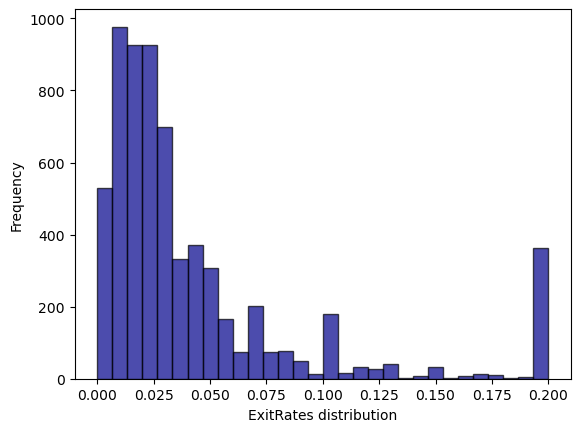

In [7]:
plot = plt.hist(np.array(y_train), bins=30, color="darkblue", edgecolor='black', alpha=0.7)

x_lab = plt.xlabel('ExitRates distribution')
y_lab = plt.ylabel('Frequency')

plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)

## 1.2 Linear and polynomial regression

We check which is the best model along different degrees of polynomial regression. We find out that the best solution, considering all the variables, is the linear one (degree = 1).

In [8]:
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,3))}

cv = KFold(n_splits=5, random_state=42, shuffle=True)
model_cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=cv, refit=True)
model_cv.fit(X_train, y_train)
best_polynomial_model = model_cv.best_estimator_
print("Best Hyperparameters:", model_cv.best_params_)
print("Best R-squared Score:", model_cv.best_score_)

Best Hyperparameters: {'poly__degree': 1}
Best R-squared Score: 0.8609495385172083


Once assessed that the linear regression model with degree equal to 1 is the best one among different degrees, we train that model with all the varibles. Then, we will try to improve this result using Ridge, Lasso or Forward Stepwise Selection.

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

cv = KFold(n_splits=5, random_state=42, shuffle=True)
MSE = cross_val_score(lin_reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
MSE = np.mean(-MSE)
r2_lin_reg = cross_val_score(lin_reg, X_train, y_train, cv=cv, scoring='r2')
r2_lin_reg = np.mean(r2_lin_reg)

print("Mean Squared Error:", MSE)
print("R-squared:", r2_lin_reg)

Mean Squared Error: 0.0003216844244378587
R-squared: 0.8609495385172947


Plot of the residuals for linear regression, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

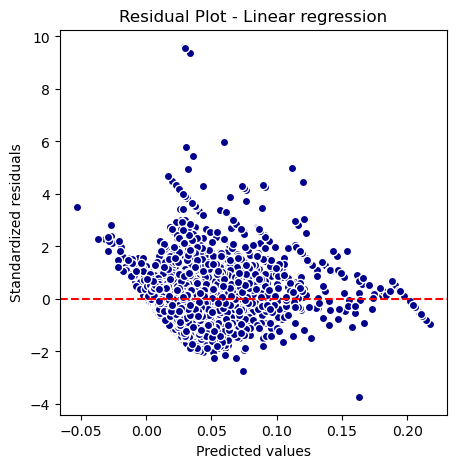

In [10]:
predicted_values = lin_reg.predict(X_train)
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot - Linear regression')
plt.show()

## 1.3 Improvements of linear regression

We now try to improve linear regression performance by using shrinkage methods (to improve accuracy) and feature selection (to improve interpretability).

In [11]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

# we scale the numeric features to have better results
X_train_scaled = X_train
X_train_scaled.iloc[:,list(range(0,9))] = scaler.fit_transform(X_train_scaled.iloc[:,list(range(0,9))])

### Ridge regression

The $R^2$ is almost equal to the one of the standard linear model. It is coherent, because all our coefficients are very small and Ridge regression is more appropriate when we have some high coefficients that we want to shrink near 0.

In [12]:
from sklearn.linear_model import Ridge

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0]
}

pipeline = Pipeline([
    ('ridge', Ridge())
])

cv = KFold(n_splits=5, random_state=42, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv)
grid_search.fit(X_train_scaled, y_train)
best_alpha = grid_search.best_params_['ridge__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)

Best alpha: 10.0


In [13]:
best_model_ridge = grid_search.best_estimator_

MSE = cross_val_score(best_model_ridge, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
MSE = np.mean(-MSE)
r2_ridge = cross_val_score(best_model_ridge, X_train_scaled, y_train, cv=cv, scoring='r2')
r2_ridge = np.mean(r2_ridge)

print("Mean Squared Error:", MSE)
print("R-squared:", r2_ridge)

Mean Squared Error: 0.0003212346185581315
R-squared: 0.8611378313812716


Plot of the residuals for linear regression with Ridge, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

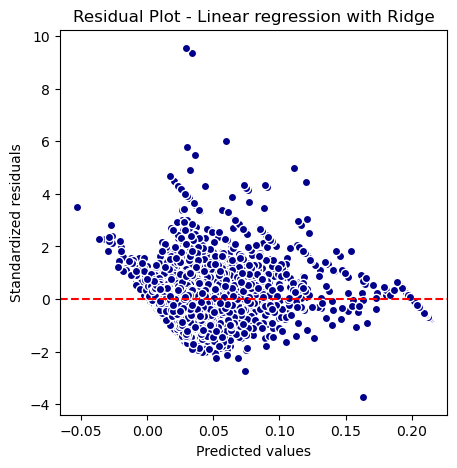

In [14]:
predicted_values = best_model_ridge.predict(X_train_scaled)
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot - Linear regression with Ridge')
plt.show()

### Lasso

In [15]:
from sklearn.linear_model import Lasso

param_grid = {
    'lasso__alpha': [0.0005, 0.001, 0.01, 0.1, 1.0, 10.0] 
}

pipeline = Pipeline([
    ('lasso', Lasso())
])

cv = KFold(n_splits=5, random_state=42, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv)
grid_search.fit(X_train_scaled, y_train)
best_alpha = grid_search.best_params_['lasso__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)

Best alpha: 0.0005


In [16]:
best_model_lasso = grid_search.best_estimator_

MSE = cross_val_score(best_model_lasso, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
MSE = np.mean(-MSE)
r2_lasso = cross_val_score(best_model_lasso, X_train_scaled, y_train, cv=cv, scoring='r2')
r2_lasso = np.mean(r2_lasso)

print("Mean Squared Error:", MSE)
print("R-squared:", r2_lasso)

print("Number of features maintained:", np.count_nonzero(np.array(best_estimator.named_steps['lasso'].coef_)))

non_zero_coeffs = best_model_lasso.named_steps['lasso'].coef_ != 0
features = X_train.columns[non_zero_coeffs]

print("Features maintained:", features)

Mean Squared Error: 0.0003277673456211589
R-squared: 0.8583211625837895
Number of features maintained: 9
Features maintained: Index(['Administrative', 'Administrative_Duration', 'ProductRelated',
       'BounceRates', 'PageValues', 'SpecialDay', 'OperatingSystems_2',
       'TrafficType_2', 'VisitorType_New_Visitor'],
      dtype='object')


Plot of the residuals for linear regression with Lasso, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

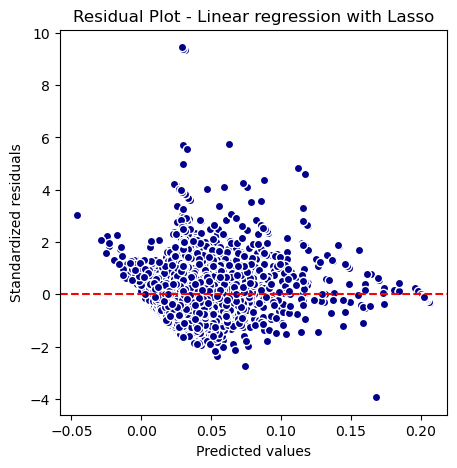

In [17]:
predicted_values = best_model_lasso.predict(X_train_scaled)
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot - Linear regression with Lasso')
plt.show()

### Linear regression vs linear regression with Ridge and Lasso

Here is shown the comparison between Ridge and Lasso coefficients. 

To perform an accurate evaluation of the models we compute the RMSE throug 5-cv. Results are very similar. So, Ridge is useless, while maybe we can consider Lasso because it gives the same results of simple linear regression, but it performs feature selection, keeping only 16 features.

In [18]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Linear Regression
linear_reg_score = cross_val_score(lin_reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
linear_reg_rmse = np.sqrt(-linear_reg_score.mean())

# Ridge Regression
ridge_reg_score = cross_val_score(best_model_ridge, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
ridge_reg_rmse = np.sqrt(-ridge_reg_score.mean())

# Lasso Regression
lasso_reg_score = cross_val_score(best_model_lasso, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
lasso_reg_rmse = np.sqrt(-lasso_reg_score.mean())

# Evaluation
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
rmse_scores = [linear_reg_rmse, ridge_reg_rmse, lasso_reg_rmse]

for model, rmse_score in zip(models, rmse_scores):
    print(f"{model}: RMSE = {rmse_score}")

Linear Regression: RMSE = 0.018009976891742566
Ridge Regression: RMSE = 0.01792301923667247
Lasso Regression: RMSE = 0.01810434604235013


### Forward stepwise selection

We now perform forward stepwise selection with cross validation on the simple linear regression model.

In [19]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator


possible_models = {
    "LogisticRegression":LogisticRegression(solver="newton-cg", penalty='none',max_iter=1000),
    "LDA":LDA(),
    "QDA":QDA(),
    #"KNN":KNeighborsClassifier(n_neighbors=6),
    "LinearRegression":LinearRegression(fit_intercept=True),
}

#da qui inizia il ctrl Z

def forward_selection(Xtrain_pd, ytrain, model_chosen,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    
    
    for dim in range(num_features):
        candidate_metrics = [] # metrics for all the models with dim features
        candidate_models = []  # models with dim features
        
        remaining_features = all_features.difference(selected_features)
        
        # fit all the models with k features
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = possible_models[model_chosen]
            #print(new_column)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        
        idx_best_candidate = candidates_argbest(candidate_metrics) # select the best Mk model
        selected_features.append(remaining_features[idx_best_candidate]) # Update selected feature
        best_candidate_metric.append(candidate_metrics[idx_best_candidate]) # Save best candidate features
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for the final step -> comparison of all the best models
        best_subset_model = candidate_models[idx_best_candidate] # save the best model
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score) #computing the metrics for the training set
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim+1, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim+1, score))
        
    # choose the best candidates
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n Best configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    return best_features
    

In [20]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
features_lin_reg = forward_selection(X_train, y_train, "LinearRegression",
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(r2_score), cv), np.argmax, # 3.
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="R^2 (CV)",
                  verbose=False, weight_step3=cv.n_splits)
print("The best model has {} features".format(len(features_lin_reg)))
features_lin_reg

The best model has 22 features


['BounceRates',
 'Administrative',
 'ProductRelated',
 'VisitorType_New_Visitor',
 'PageValues',
 'TrafficType_2',
 'OperatingSystems_2',
 'SpecialDay',
 'TrafficType_4',
 'Month_June',
 'OperatingSystems_3',
 'TrafficType_3',
 'TrafficType_13',
 'TrafficType_1',
 'Month_Dec',
 'Region_7',
 'TrafficType_19',
 'VisitorType_Other',
 'Browser_13',
 'ProductRelated_Duration',
 'OperatingSystems_6',
 'Region_9']

In [21]:
best_model_forward = LinearRegression(fit_intercept=True)
best_model_forward = best_model_forward.fit(X_train[features_lin_reg],y_train)

MSE = cross_val_score(best_model_forward, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
MSE = np.mean(-MSE)
r2_forward = cross_val_score(best_model_forward, X_train_scaled, y_train, cv=cv, scoring='r2')
r2_forward = np.mean(r2_forward)

print("Mean Squared Error:", MSE)
print("R-squared:", r2_forward)

Mean Squared Error: 0.00032435926764110115
R-squared: 0.8597792551540218


Plot of the residuals for linear regression with forward stepwise selection, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

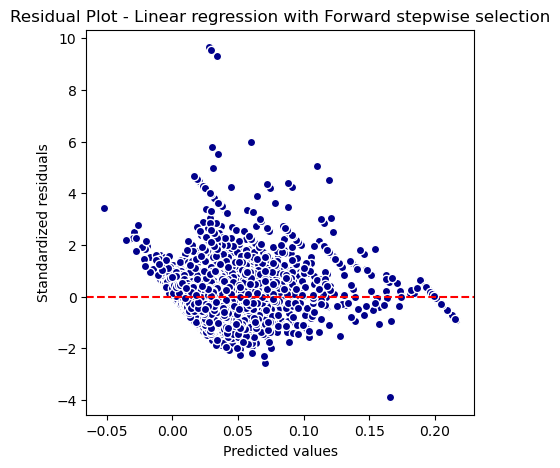

In [22]:
predicted_values = best_model_forward.predict(X_train[features_lin_reg])
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot - Linear regression with Forward stepwise selection')
plt.show()

## 1.4 KNN algorithm

We now repeat the analysis using a different method, the K-Nearest Neighbors. This algorithm has problems when the dimension of the dataset is too high (curse of dimensionality), so we use it involving only the 9 numerical variables.

In [23]:
# Questo lo avremo già nel codice intero
df_num = pd.DataFrame({'Administrative':training_set['Administrative'],
                   'Administrative_Duration':training_set['Administrative_Duration'],
                   'Informational':training_set['Informational'],
                   'Informational_Duration':training_set['Informational_Duration'],
                   'ProductRelated':training_set['ProductRelated'], 
                   'ProductRelated_Duration':training_set['ProductRelated_Duration'],
                   'BounceRates':training_set['BounceRates'], 
                   'ExitRates':training_set['ExitRates'],
                   'PageValues':training_set['PageValues'], 
                   'SpecialDay':training_set['SpecialDay']})
df_num = df_num[df_num['ExitRates'].isna()==False]

In [24]:
X_train_num = df_num.drop(columns='ExitRates')
y_train_num = df_num['ExitRates']

X_train_num_scaled = scaler.fit_transform(X_train_num)

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)

cv = KFold(n_splits=5, random_state=42, shuffle=True)

params = {'n_neighbors': range(1, 30)}

KNR = KNeighborsRegressor()
KNR_cv = GridSearchCV(KNR, params, refit=True, cv=cv, scoring='r2')
KNR_cv.fit(X_train_num, y_train)
print("Best number of neighbours: {}".format(KNR_cv.best_params_['n_neighbors']))


knn_regressor = KNeighborsRegressor(n_neighbors=KNR_cv.best_params_['n_neighbors'])
r2_KNN = cross_val_score(knn_regressor, X_train_num, y_train_num, cv=cv, scoring='r2')
mean_r2_KNN = r2_KNN.mean()
print("R^2:", mean_r2_KNN)

Best number of neighbours: 11
R^2: 0.7657364695918126


Plot of the residuals for linear regression with Lasso, to assess if our regression hypotheses are correct. The plot shows no particular pattern, residuals seem to be random distributed, so the assumptions are not violated.

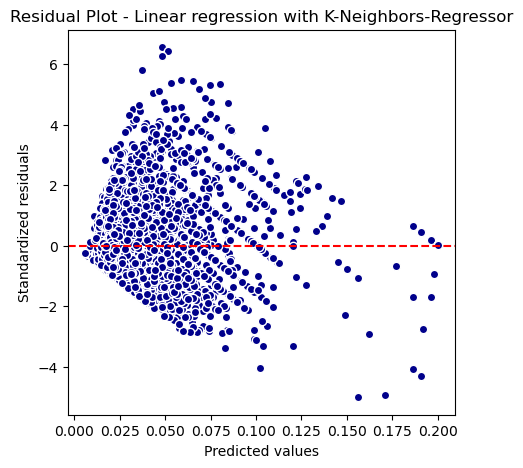

In [26]:
knn_regressor = knn_regressor.fit(X_train_num,y_train)
predicted_values = knn_regressor.predict(X_train_num)
residuals = y_train - predicted_values
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(5, 5))
plt.scatter(predicted_values, standardized_residuals, color='darkblue', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Standardized residuals')
plt.title('Residual Plot - Linear regression with K-Neighbors-Regressor')
plt.show()

## 1.5 Model comparision

Sono tutti uguali tranne KNN che è più basso. Escludiamo KNN perchè ha problemi sull'alta dimensionalità ecc. Tra tutti gli altri modelli, che hanno praticamente lo stesso errore, decidiamo di usare lasso o forward perchè tengono meno variabili e danno gli stessi risultati. Alla fine scegliamo ... perchè ...

In [27]:
print("R^2 for linear regression: {}".format(r2_lin_reg))
print("R^2 for linear regression with Ridge: {}".format(r2_ridge))
print("R^2 for linear regression with Lasso: {}".format(r2_lasso))
print("R^2 for linear regression with forward stepwise selection: {}".format(r2_forward))
print("R^2 for KNN: {}".format(mean_r2_KNN))

R^2 for linear regression: 0.8609495385172947
R^2 for linear regression with Ridge: 0.8611378313812716
R^2 for linear regression with Lasso: 0.8583211625837895
R^2 for linear regression with forward stepwise selection: 0.8597792551540218
R^2 for KNN: 0.7657364695918126


## 1.6 Filling missing values

In [30]:
# Filling missing values in the training set
#X_missing = missing_values[features_lin_reg].to_numpy()
#X_missing.shape
X_missing = missing_values[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'PageValues', 'SpecialDay', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_6', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_13', 'TrafficType_15', 'TrafficType_19', 'TrafficType_20', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True']]
values = best_model_lasso.predict(X_missing)
values = np.where(values < 0, 0, values)
values = np.where(values > 1, 1, values)
training_set_complete.loc[:,'ExitRates'] = training_set_complete.loc[:,'ExitRates'].fillna(pd.Series(values,missing_values.index))
training_set_complete

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True
0,0,0.000000,0,0.0,5,19.000000,0.000000,0.080000,0.000000,0.6,...,0,0,0,0,0,0,0,1,1,0
1,5,158.700000,0,0.0,51,1364.266667,0.007692,0.011987,0.000000,0.0,...,0,0,0,0,0,0,0,1,0,1
2,7,87.916667,1,0.0,46,1621.025379,0.004082,0.020544,6.023523,0.0,...,0,0,0,0,0,0,0,1,1,0
3,1,4.000000,0,0.0,37,1296.942857,0.013889,0.000000,0.000000,0.8,...,0,0,0,0,0,0,0,1,1,0
4,2,132.400000,0,0.0,11,296.300000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9243,10,130.550000,1,23.2,7,128.233333,0.006667,0.015238,0.000000,0.0,...,0,0,0,0,0,1,0,0,1,0
9244,14,260.736111,3,186.5,51,2921.902778,0.013661,0.029891,8.339172,0.0,...,0,0,0,0,0,0,0,1,0,1
9245,7,109.500000,0,0.0,25,349.696970,0.000000,0.019048,0.000000,0.0,...,0,0,0,0,0,0,0,1,1,0
9246,4,82.700000,0,0.0,26,405.283333,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,1,0,0,1,0


In [31]:
test_set = pd.read_csv("data/training_set_online_shoppers_intention.csv")
test_set = test_set.drop(columns=['Unnamed: 0'])

test_set['Month']=test_set['Month'].astype('category')
test_set['OperatingSystems']=test_set['OperatingSystems'].astype('category')
test_set['Browser']=test_set['Browser'].astype('category')
test_set['Region']=test_set['Region'].astype('category')
test_set['TrafficType']=test_set['TrafficType'].astype('category')
test_set['VisitorType']=test_set['VisitorType'].astype('category')
test_set['Weekend']=test_set['Weekend'].astype('category')
test_set['Revenue']=test_set['Revenue'].astype('category')

In [32]:
#test_set = pd.read_csv("data/test_set_online_shoppers_intention.csv")
test_set['Browser'] = test_set['Browser'].cat.set_categories(all_categories_browser)
test_set['TrafficType'] = test_set['TrafficType'].cat.set_categories(all_categories_traffic_type)
#test_set = pd.get_dummies(test_set, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend'], drop_first=False)
#test_set['Weekend'] = np.where(test_set['Weekend']=='True',1,0)

In [33]:
test_set = pd.get_dummies(test_set, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend'], drop_first=False)

In [35]:
missing_values_test = test_set[test_set['ExitRates'].isna()]
X_missing_test = missing_values_test[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'PageValues', 'SpecialDay', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_6', 'OperatingSystems_8', 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7', 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_13', 'TrafficType_15', 'TrafficType_19', 'TrafficType_20', 'VisitorType_New_Visitor', 'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True']]
values_test = best_model_lasso.predict(X_missing_test)
#X_missing_test = missing_values_test[best_features].to_numpy()
#X_missing_test.shape
#values_test = best_model_forward.predict(X_missing_test)
values_test = np.where(values_test < 0, 0, values_test)
values_test = np.where(values_test > 1, 1, values_test)
test_set.loc[:,'ExitRates'] = test_set.loc[:,'ExitRates'].fillna(pd.Series(values_test,missing_values_test.index))
test_set

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True
0,0,0.000000,0,0.0,5,19.000000,0.000000,0.080000,0.000000,0.6,...,0,0,0,0,0,0,0,1,1,0
1,5,158.700000,0,0.0,51,1364.266667,0.007692,0.011987,0.000000,0.0,...,0,0,0,0,0,0,0,1,0,1
2,7,87.916667,1,0.0,46,1621.025379,0.004082,0.020544,6.023523,0.0,...,0,0,0,0,0,0,0,1,1,0
3,1,4.000000,0,0.0,37,1296.942857,0.013889,0.000000,0.000000,0.8,...,0,0,0,0,0,0,0,1,1,0
4,2,132.400000,0,0.0,11,296.300000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9243,10,130.550000,1,23.2,7,128.233333,0.006667,0.015238,0.000000,0.0,...,0,0,0,0,0,1,0,0,1,0
9244,14,260.736111,3,186.5,51,2921.902778,0.013661,0.029891,8.339172,0.0,...,0,0,0,0,0,0,0,1,0,1
9245,7,109.500000,0,0.0,25,349.696970,0.000000,0.019048,0.000000,0.0,...,0,0,0,0,0,0,0,1,1,0
9246,4,82.700000,0,0.0,26,405.283333,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,1,0,0,1,0


In [36]:
training_set_complete.to_csv("training_set_complete.csv", index=False)
test_set.to_csv("test_set_complete.csv", index=False)